# Поиск клиентов с неоптимальными тарифами

**Цели проекта:** 
1. Изучить текущее положение дел с предоставлением услуг связи по тарифам А, В, С.
2. Найти клиентов с неоптимальными тарифами и оценить возможности по предоставлению оптимальных.

**Этапы проекта:**

**<a href="#prepare">1. Подготовка данных.</a>** Данные будут <a href="#load">загружены</a>, <a  href="#prepare">проверены</a> и при необходимости исправлены. 

**<a href="#discovery">2. Исследование данных.</a>** На основе исходных данных будет выполнен расчёт объёма и стоимости услуг связи для каждого абонента за каждый месяц (<a href="#billing">биллинг</a>). Далее будут составлены портреты среднестатистического <a href="#clients">клиента</a>, <a href="#tariffs">тарифов</a> и их <a href="#users">пользователей</a>.

**<a href="#tariffs-best">3. Выбор оптимальных тарифов.</a>** На основе биллинга будет проанализировано, все ли клиенты подключены к оптимальным тарифам, кто из них может сэкономить, сменив тариф, насколько снизится <a href="#income-lost">доход</a>, если все клиенты перейдут на оптимальные тарифы, и как снизить <a href="#risk">риск</a> и <a href="#calculator">компенсировать</a> снижение дохода.

**<a href="#hypos">4. Гипотезы.</a>** Будут проверена статистическая значимость <a href="#hypo-low-income">снижения доходов</a> после выбора пользователями оптимальных тарифов, а также то, что характеристики пользователей тарифа В <a href="#hypo-b-better-c">превосходят</a> характеристики пользователей тарифа С.

**<a href="#final">5. Итоги.</a>** В заключение будут подведены итоги проекта: сделаны основные выводы о положении дел с предоставлением услуг связи, а также даны рекомендации по улучшению ситуации с тарифами.

**Примечания:**

1. Более детально структуру проекта можно посмотреть в автоматическом оглавлении тетради.

2. По проекту подготовлена <a href="https://drive.google.com/file/d/1qycJoWsG_0htCg8GW5WkiHddBM3lKc_l/view?usp=sharing">презентация-отчёт</a> для генерального директора.

3. Часть исследования представлена в виде интерактивного <a href="https://public.tableau.com/app/profile/zaikin.alex/viz/calls-dash/Dashboard">дашборда</a>.

<a id="prepare"></a>

## Подготовка данных

Подключим все необходимые для дальнейшей работы программные модули:

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st

<a id="load"></a>

### Загрузка данных

Загрузим данные из файлов в память:

In [2]:
clients = pd.read_csv('data/telecom_clients.csv')
calls = pd.read_csv('data/telecom_dataset.csv')

Проверим загрузку:

In [3]:
clients.head(3)

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29


In [4]:
calls.head(3)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1


Структура данных соответствует описанию - загрузка произведена корректно.

<a id="prepare"></a>

### Предобработка данных

В каждом столбце каждого набора проверим данные на наличие пропусков, некорректных значений, дублей и неверных типов. Исправим обнаруженные недостатки.

#### Набор данных clients

##### user_id

Проверим тип значений:

In [5]:
clients['user_id'].dtype

dtype('int64')

Тип значений соответствует хранимым в столбце данным.

Проверим наличие пропусков:

In [6]:
clients['user_id'].isna().mean()

0.0

Пропусков нет.

Проверим корректность значений - выясним их диапазон:

In [7]:
clients['user_id'].min(), clients['user_id'].max()

(166373, 168606)

Идентификаторы клиентов находятся в подходящем диапазоне - некорректных значений нет.

Проверим значения на уникальность:

In [8]:
clients['user_id'].duplicated().mean()

0.0

Дублей нет - все значения уникальны.

##### tariff_plan

Для удобства сократим название столбца:

In [9]:
clients = clients.rename(columns={'tariff_plan':'tariff'})

Проверим наличие пропущенных значений:

In [10]:
clients['tariff'].isna().mean()

0.0

Пропущенных значений нет.

Проверим корректность значений и их тип:

In [11]:
clients['tariff'].unique()

array(['A', 'C', 'B'], dtype=object)

Значения и их тип корректны.

##### date_start

Проверим тип значений:

In [12]:
clients['date_start'].dtype

dtype('O')

Тип неверен, изменим его:

In [13]:
clients['date_start'] = pd.to_datetime(clients['date_start'], infer_datetime_format=True)

Проверим наличие пропущенных значений:

In [14]:
clients['date_start'].isna().mean()

0.0

Пропущенных значений нет.

Проверим корректность значений по диапазону:

In [15]:
clients['date_start'].min(), clients['date_start'].max()

(Timestamp('2019-08-01 00:00:00'), Timestamp('2019-10-31 00:00:00'))

Диапазон не вызывает сомнений.

Проверим распределение:

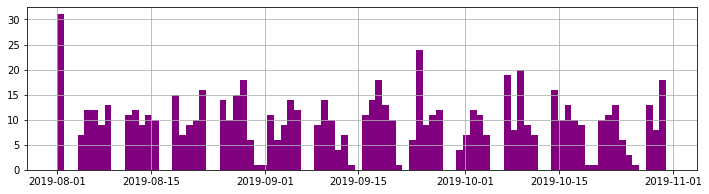

In [16]:
clients['date_start'].hist(figsize=(12,3), bins=30*3, color='purple')
plt.show()

Распределение вполне естественное: подключение к тарифам в основном по будням, примерно на одинаковом уровне. Заметных аномалий в распределении нет. Пик 01.08.2019 объясняется, скорее всего, либо ярким рекламным мероприятием в этот день (выставка/конференция на тему телекоммуникаций, обзовон потенциальных клиентов), либо единомоментной регистрацией в этот день ранее накопленных заявок на подключение.

#### Набор данных calls

##### user_id

Проверим тип значений:

In [17]:
calls['user_id'].dtype

dtype('int64')

Тип значений соответствует хранимым в столбце данным.

Проверим наличие пропусков:

In [18]:
calls['user_id'].isna().mean()

0.0

Пропусков нет.

Проверим корректность значений по диапазону:

In [19]:
calls['user_id'].min(), calls['user_id'].max()

(166377, 168606)

Идентификаторы клиентов находятся в подходящем диапазоне - некорректных значений нет.

Проверим, все ли идентификаторы клентов из набора calls присутствуют в наборе clients:

In [20]:
calls['user_id'].isin(clients['user_id']).mean()

1.0

Да, все клиенты (100%) из набора calls, присутствуют в наборе clients.

Проверим обратное: для всех ли клиентов из набора clients, есть записи в наборе calls:

In [21]:
clients['user_id'].isin(calls['user_id']).mean()

0.41939890710382516

Для 58% клиентов из clients нет записей об использовании услуг связи в calls. Быть может эти клиенты только-только подключились и ещё не начали работать. Посмотрим моменты подключений:

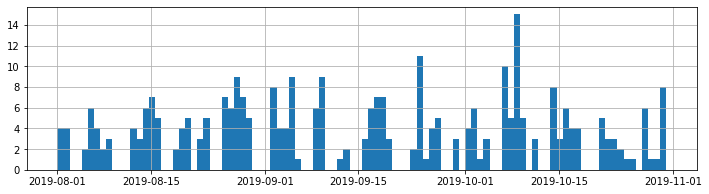

In [22]:
clients[clients['user_id'].isin(calls['user_id'])]['date_start'].hist(
    figsize=(12,3), bins=100)
plt.show()

Многие из неактивных клиентов подключились уже давно (несколько месяцев назад), но всё ещё не начали пользоваться связью. Это крайне нерациональное поведение. И его демонстрирует 58% клиентов. Из чего следует, что пассивные клиенты включены в данные по ошибке. Исключим их из набора clients:

In [23]:
clients = clients[clients['user_id'].isin(calls['user_id'])]

##### date

Проверим тип значений:

In [24]:
calls['date'].dtype

dtype('O')

Тип неверен, изменим его:

In [25]:
calls['date'] = pd.to_datetime(calls['date'], infer_datetime_format=True)

Проверим наличие пропущенных значений:

In [26]:
calls['date'].isna().mean()

0.0

Пропущенных значений нет.

Проверим корректность значений по диапазону (сравним с диапазоном дат из calls):

In [27]:
clients['date_start'].min(), clients['date_start'].max()

(Timestamp('2019-08-01 00:00:00'), Timestamp('2019-10-31 00:00:00'))

In [28]:
calls['date'].min(), calls['date'].max()

(Timestamp('2019-08-02 00:00:00+0300', tz='pytz.FixedOffset(180)'),
 Timestamp('2019-11-28 00:00:00+0300', tz='pytz.FixedOffset(180)'))

Врямя, за которое есть данные и в calls и в clients, почти совпадает. Отличие одно: в calls есть дополнительно данные за ноябрь. Это нормально. Для клиентов, зарегистрированных в конце октября мы имеем как минимум один месяц с информацией о звонках, а клиентов, зарегистрирированных в ноябре, нам знать не надо, т.к. по ним нет полного месяца использования услуг связи. Таким образом, диапазоны дат в calls и clients правильно синхронизированы и верны.

Проверим распределение:

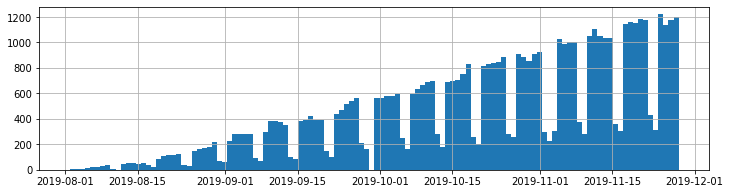

In [29]:
calls['date'].hist(figsize=(12,3), bins=30*4)
plt.show()

Распределение вполне естественное: по мере подключения новых и новых клиентов объём вызовов растёт. Кроме того в данных чётко просматривается недельный цикл: повышенное число звонков в будние дни и сниженное в выходные. Аномалий нет. Данные верны.

##### direction

Проверим наличие пропущенных значений:

In [30]:
calls['direction'].isna().mean()

0.0

Пропущенных значений нет.

Проверим корректность значений и их тип:

In [31]:
calls['direction'].unique()

array(['in', 'out'], dtype=object)

Значения и их тип корректны.

##### internal

Проверим, тип и значения в столбце:

In [32]:
calls['internal'].unique()

array([False, True, nan], dtype=object)

В столбце есть пропуски. Тип столбца не соответствует типу хранимых значений. 

Сначала оценим число записей с пропусками и их долю в общем числе записей:

In [33]:
x = calls['internal'].isna()
x.sum(), x.mean()

(117, 0.0021706059144373123)

Пропусков незначительное число. Восстановить пропущенные значения исходя из значений других столбцов не представляется возможным. Вероятная причина пропусков - технический сбой. Пропуски придётся удалить:

In [34]:
calls = calls[~x]

Осталось исправить тип столбца:

In [35]:
calls['internal'] = calls['internal'].astype('bool')

##### operator_id

Узнаем число пропущенных значений (в абсолютном и относительном выражении):

In [36]:
x = calls['operator_id'].isna()
x.sum(), x.mean()

(8115, 0.15087849772241332)

Пропущено значительное число значений.

Разберёмся подробнее, в каких случаях оператор не указан. Рассмотрим направление вызовов:

In [37]:
calls[x]['direction'].value_counts(normalize=True)

in     0.975601
out    0.024399
Name: direction, dtype: float64

В подавляющем большинстве случаев оператор не указан для входящих вызовов. Посмотрим, состоялось ли соединение (разговор):

In [38]:
calls[x]['is_missed_call'].mean()

0.984966112138016

Почти все вызовы, для которых оператор не указан (независимо от направления) закончились неудачей (разговор не состоялся).

Следовательно основной ситуацией, когда оператор не указывается, является поступление вызова в момент, когда все операторы заняты и не ответили (звонящий положил трубку прежде, чем кто-либо из операторов освободился). Данные о таких вызовах можно удалить, т.к. несостоявшиеся вызовы без указания оператора в данном исследовании нас не интересуют:

In [39]:
calls = calls[~(x & (calls['direction']=='in') & calls['is_missed_call'])]

В остальных ситуациях (исходящий вызов и/или состоявшийся разговор) оператор должен быть указан, а если это не так, то единственное объяснение этому - технический сбой. Выясним число таких записей:

In [40]:
x = calls['operator_id'].isna()
x.sum(), x.mean()

(271, 0.0058988702901547636)

Число сбойных записей незначительное - удалим их:

In [41]:
calls = calls[~x]

Пропуски исключены.

Проверим тип столбца:

In [42]:
calls['operator_id'].dtype

dtype('float64')

Проверим, действительно ли значения представлены числами с плавающей запятой:

In [43]:
(calls['operator_id'] != calls['operator_id'].round()).sum()

0

Ни у одного идентификатора не обнаружено дробной части, значит идентификаторы - целые числа. Соответственно исправим тип:

In [44]:
calls['operator_id'] = calls['operator_id'].astype('int')

##### is_missed_call

Проверим пропуск значений:

In [45]:
calls['is_missed_call'].isna().sum()

0

Пропущенных значений нет.

О том, состоялся разговор или нет, можно судить не только по столбцу is_missing_call, но и по столбцу call_duration. Проверим, есть ли несогласованность взначениях столбцов:

In [46]:
x = (~calls['is_missed_call'] & (calls['call_duration'] == 0)) \
    | (calls['is_missed_call'] & (calls['call_duration'] > 0))
x.sum(), x.mean()

(344, 0.007532296912634114)

Рассинхронизация значений в столбцах is_missing_call и call_duration встречается в незначительном числе строк. Причиной этого может быть только технический сбой. Противоречивым данным доверять нельзя - придётся удалить строки с ними:

In [47]:
calls = calls[~x]

Теперь столбец is_missed_call больше не нужен, его можно удалить:

In [48]:
calls = calls.drop(columns=['is_missed_call'])

##### calls_count

Для удобства дадим столбцу более короткое имя:

In [49]:
calls = calls.rename(columns={'calls_count':'count'})

Проверим тип столбца:

In [50]:
calls['count'].dtype

dtype('int64')

Тип столбца соответствет характеру хранимой информации.

Проверим, нет ли пропущенных значений:

In [51]:
calls['count'].isna().mean()

0.0

Пропущенных значений нет.

Проверим корректность значений, исследовав их диапазон:

In [52]:
calls['count'].min(), calls['count'].max()

(1, 4817)

Верхняя граница диапазона кажется слишком большой. Посмотрим диаграмму размаха:

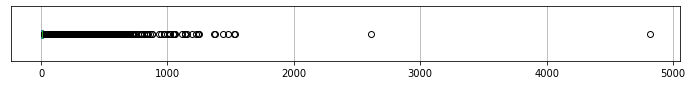

In [53]:
calls.boxplot(column='count', figsize=(12,1), vert=False)
plt.yticks([])
plt.show()

Согласно диаграмме значений, близких к верхней границе диапазона нет. Убедимся в этом: 

In [54]:
(calls['count'] > 4000).sum()

1

Предположим, что большие значения - это выбросы. Узнаем их количество по стандартной методике полуторного межквартильного размаха:

In [55]:
q = calls['count'].quantile([0.25, 0.75])
q1, q3 = q[0.25], q[0.75]
limit = q3 + 1.5 * (q3 - q1)
x = (calls['count'] > limit).sum()
x, x / calls.shape[0]

(5289, 0.11668799364603098)

Методика определила как выбросы слишком большое число значений. Скорее всего, большое число вызовов характерно для операторов, серийно обзванивающих большие группы людей в ходе программ информирования или в рекламных целях. Для этого могут использоваться роботы или посменно работающие сотрудники call-центров. Определим предельные возможности таких операторов:

In [56]:
limit = 24 * 60 * 2
limit

2880

Таким образом, если оператор совершает в среднем 2 звонка в минуту, то он успеет сделать 2880 вызовов за сутки. В среднем 30 сек. на вызов. Если большинство абонентов не желают слушать сообщение и почти сразу бросают трубку, то на вызов может тратиться меньше времени, например, вдвое, тогда число вызовов (в среднем) вдвое возрастёт 2880 * 2 = 5760. Самые большие числа вызовов в наборе данных не превосходят это число (4817 < 5760), значит их нельзя считать выбросами. Данные корректны.  

##### call_duration

Переименуем столбец для удобства:

In [57]:
calls = calls.rename(columns={'call_duration':'duration'})

Проверим наличие пропусков:

In [58]:
calls['duration'].isna().mean()

0.0

Пропусков нет.

Проверим тип столбца:

In [59]:
calls['duration'].dtype

dtype('int64')

Тип соответствет хранимым данным (длительность соединений в секундах).

Проверим значения столбца по масимальной длительности соединений. При этом учтём, что длительность, равная нулю, установлена для вызовов, не закончившихся соединением (разговором), а если длительность больше нуля, то это суммарная длительность того числа звонков, которые агрегированы в этой строке данных:

In [60]:
x = calls['duration'] > 0
y = calls.loc[x, 'duration'] / calls.loc[x, 'count']
y.min(), y.max()

(0.5, 3550.0)

Разговоры длятся от полсекунды до часа (60 * 60 = 3600). Само по себе значение верхней границы не вызывает сомнений, однако, возможно, если проссумировать записи из расчёта на оператора, то сумма соединений превысит пределы человеческих возможностей. Проверим, нет ли таких операторов, сумма разговоров которых за сутки превышает 10 часов (рабочий день с запасом):

In [61]:

wrong_operators = (
 calls.drop_duplicates()
 .groupby(['operator_id','date'])
 .agg({'duration' : 'sum'})
 .reset_index()
 .query('duration > (60*60*10)')['operator_id']
 .unique()
)
calls['operator_id'].isin(wrong_operators).sum() / calls.shape[0]

0.019922340378590656

Такие операторы существуют - их 2% от общего числа операторов. Их наличие можно объяснить только ошибкой в сборе данных. Удалим данные по таким операторам:

In [62]:
calls = calls[~calls['operator_id'].isin(wrong_operators)]

Данные по операторам со сверхпоказателями удалены!

Теперь проверим нижнюю границу длительности разговора:

In [63]:
(y < 5).mean()

0.013905021073241961

Соединения меньше полсекунды редки. Скорее всего, это случаи, 1) когда абонент случайно нажал подряд кнопки приёма и отбоя звонка подряд, 2) когда вызываемый уже поднял трубку, но вызывающий положил её почти в тот же момент, думая, что не дождётся ответа, 3) когда связь обрывалась по техническим причинам: слабый сигнал, разряжен аккумулятор и т.п. 

Проверим размах и распределение вызовов по длительности соединения:

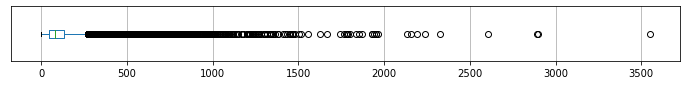

In [64]:
y.to_frame().boxplot(figsize=(12,1), vert=False)
plt.yticks([])
plt.show()

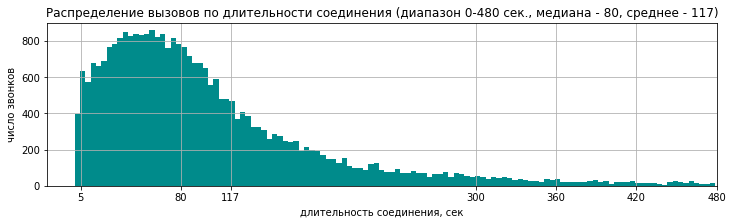

In [65]:
y[y<480].hist(figsize=(12,3), bins=120, color='darkcyan')
plt.title('Распределение вызовов по длительности соединения ' 
    '(диапазон 0-480 сек., медиана - {:.0f}, среднее - {:.0f})'.format(y.median(), 
    y.mean()))
plt.xticks([5, round(y.median()), round(y.mean()), 300, 360, 420, 480])
plt.xlim((-20,480))
plt.xlabel('длительность соединения, сек')
plt.ylabel('число звонков')
plt.show()

Распределение для длительности звонков вполне естественное, аномалий не наблюдается. Данные корректны.

##### total_call_duration

Данные о длительности звонков с учётом ожидания не будут использоваться в настоящем проекте: для биллинга эти данные бесполезны, а технические аспекты (время использования линий связи) выходят за рамки исследования. Удаляем столбец:

In [66]:
calls = calls.drop(columns=['total_call_duration'])

##### Дублирование строк

Проверим, нет ли дублирования строк в наборе данных:

In [67]:
calls.duplicated(keep='first').sum()

4059

Дубли имеются (возможно появились после удаления столбцов или были изначально). Удаляем дубли:

In [68]:
calls = calls.drop_duplicates()

##### Синхронизация clients-calls

В ходе предобработки набора calls возможно из набора исчезли некоторые клиенты, которые присутствуют в наборе clients. Проверим это:

In [69]:
x = ~clients['user_id'].isin(calls['user_id'])
x.sum(), x.mean()

(18, 0.05863192182410423)

Да, небольшое количество клиентов исчезло из calls из-за некорректных данных по ним. Удалим этих клиентов также из набора clients:

In [70]:
clients = clients[~x]

### Презентация

В целях создания презентации создадим функцию сохранения диаграмм в файлах на диске:

In [71]:
savefig_file_number = 0
def savefig():
    global savefig_file_number
    #plt.savefig(
    #    '/home/alex/Documents/ya-praktikum/analyst/projects'
    #    '/final/slides/{:03.0f}.png'.format(savefig_file_number),
    #    dpi=200, transparent='true')
    savefig_file_number += 1

### Дашборд

Выгрузим данные для интерактивного дашборда:

In [72]:
dash = calls.drop(columns=['user_id','operator_id','duration'])
dash['date'] = dash['date'].dt.date.astype('datetime64[D]')
dash = dash.groupby(['date','direction','internal'])['count'].sum()
dash = dash.reset_index()
dash['direction'] = dash['direction'].map({'in':'входящий', 'out':'исходящий'})
dash['internal'] = dash['internal'].map({True:'внутренний', False:'внешний'})
#dash.to_csv(
#    '/home/alex/Documents/ya-praktikum/analyst/projects/final/data/dash-final.csv',
#    index=False)

### Итоги

Данные загружены и проверены. Обнаруженные дефекты исправлены. Данные готовы к использованию.

<a id="discovery"></a>

## Исследовательский анализ

<a id="billing"></a>

### Биллинг

Выполним биллинг - расчитаем для каждого клиента за каждый месяц: 
- сколько работало операторов, 
- сколько сделано вызовов, закончившихся соединением, и какова их суммарная продолжительность:
  - исходящих внешних
  - исходящих внутренних
  - входящих внешних
- сколько стоили услуги (по тарифу клиента).

Данные биллинга будут основой дальнейшего анализа.

Скомпонуем данные, необходимые для расчёта стоимости потреблённых услуг (каждым клиентом в каждом месяце):

In [73]:
# добавляем метку месяца для последующих группировок
calls['month'] = calls['date'].dt.date.astype('datetime64[M]')

# создаём базу биллинга
bills = clients[['user_id', 'tariff']]

# добавляем в биллинг число операторов
bills = bills.merge(
    calls.groupby(['user_id', 'month'])['operator_id'].nunique().reset_index(),
    how='left', on='user_id'
    )
bills = bills.rename(columns={'operator_id':'operators'})

# добавляем в биллинг счётчики внешних (вход.и исход.) вызовов
calls_out = (
    calls[~calls['internal'] & (calls['duration'] > 0)]
    .pivot_table(values=['duration', 'count'], index=['user_id','month'], 
        columns=['direction'], aggfunc='sum')
    .reset_index()
)
calls_out.columns = ['user_id', 'month', 'in_count', 'out_count', 
    'in_duration', 'out_duration']
bills = bills.merge(calls_out, how='left', on=['user_id','month'])

# добавляем в биллинг счётчики внутренних исходящих вызовов
calls_internal = (
    calls[calls['internal'] & (calls['direction']=='out') & (calls['duration'] > 0)]
    .groupby(['user_id','month'], as_index=False)
    .agg({'count':'sum', 'duration':'sum'})
)
calls_internal = calls_internal.rename(columns={'count':'int_count', 
    'duration':'int_duration'})
bills = bills.merge(calls_internal, how='left', on=['user_id','month'])

# заполняем пропущенные значения нулями
bills = bills.fillna(0)
# 
for column in bills.columns[4:]:
    bills[column] = bills[column].astype('int')

bills.head()

,user_id,tariff,month,operators,in_count,out_count,in_duration,out_duration,int_count,int_duration
0,166713,A,2019-08-01,2,6,0,1291,0,0,0
1,166713,A,2019-09-01,2,10,0,1171,0,1,141
2,166713,A,2019-10-01,2,10,1,536,70,0,0
3,166713,A,2019-11-01,2,17,1,6388,152,0,0
4,166901,A,2019-08-01,7,26,13,709,387,21,1201


Проверим, нет ли вырожденных строк (строк где все счётчики равны 0):

In [74]:
(bills.sum(axis=1, numeric_only=True) == 0).sum()

0

Вырожденных строк нет.

Проверим, нет ли среди клиентов таких, для которых за всё время нет ни одного вызова, закончившегося соединением:

In [75]:
user_bill_total = bills.groupby('user_id')[bills.columns[4:]].sum()
x = (user_bill_total.sum(axis=1) == 0)
user_bill_total[x]

,in_count,out_count,in_duration,out_duration,int_count,int_duration
user_id,,,,,,
167122,0,0,0,0,0,0
167364,0,0,0,0,0,0
168291,0,0,0,0,0,0


Несколько таких пассивных клиентов существуют. Узнаем, каким числом операторов они располагают:

In [76]:
bills[bills['user_id'].isin(user_bill_total[x].index)]

,user_id,tariff,month,operators,in_count,out_count,in_duration,out_duration,int_count,int_duration
84,167364,C,2019-11-01,1,0,0,0,0,0,0
449,167122,B,2019-09-01,1,0,0,0,0,0,0
469,168291,B,2019-11-01,1,0,0,0,0,0,0


Операторов крайне мало. Данных клиентов можно удалить из статистики:

In [77]:
bills = bills[~bills['user_id'].isin(user_bill_total[x].index)]

Данные для биллинга собраны и проверены. Выполним расчёт стоимости услуг:

In [78]:
# Возвращает стоимость услуг исходя из тарифа и месячного потребления услуг
def get_month_bill(tariff, operators, outgoing_calls_sec, internal_calls_sec):
    
    outgoing_min = math.ceil(outgoing_calls_sec / 60)
    internal_min = math.ceil(internal_calls_sec / 60)
    internal_min = max(0, internal_min - 2000)
    
    if tariff == 'A':
        return 5000 + operators * 100 + internal_min * 0.10 + outgoing_min * 0.40
    if tariff == 'B':
        return 2000 + operators * 100 + internal_min * 0.15 + outgoing_min * 0.50
    if tariff == 'C':
        return 1000 + operators * 100 + internal_min * 0.30 + outgoing_min * 0.70
    
    raise Exception('Неизвестный тариф ' + tariff)

# Делаем биллинг по всем клиентам за каждый месяц
bills['bill'] = bills.apply(axis=1, func=lambda row: get_month_bill(
    row['tariff'], row['operators'], row['out_duration'], row['int_duration']))

bills.sample(3, random_state=120340)

,user_id,tariff,month,operators,in_count,out_count,in_duration,out_duration,int_count,int_duration,bill
612,166711,B,2019-08-01,3,0,42,0,3632,0,0,2330.5
204,166940,C,2019-08-01,2,4,2,162,556,0,0,1207.0
286,167235,C,2019-09-01,1,30,27,2459,3202,0,0,1137.8


Биллинг выполнен.

<a id="clients"></a>

### Клиенты

#### Количество клиентов

<a id="client-number-dinamics"></a>Оценим изменение числа клиентов во времени:

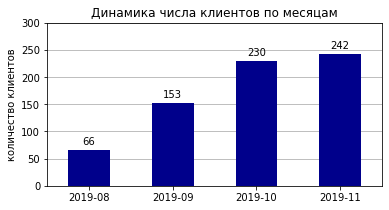

In [79]:
def annotate_bars(ax, format='{:.0f}'):
    ylim = ax.get_ylim()
    yadd = (ylim[1] - ylim[0]) / 50
    for p in ax.patches:
        b = p.get_bbox()
        val = format.format(b.height) 
        ax.annotate(val, xy=((b.x0+b.x1)/2, b.height+yadd), ha='center', va='bottom')

report = bills.groupby('month')['user_id'].count()
report.index = report.index.strftime('%Y-%m')
ax = report.plot.bar(figsize=(6,3), rot=0, color='darkblue')
ax.set_title('Динамика числа клиентов по месяцам')
ax.set_ylabel('количество клиентов')
ax.set_xlabel('')
ax.set_ylim(0,300)
ax.grid(axis='y')
ax.set_axisbelow(True)
annotate_bars(ax)
savefig()
plt.show()

За несколько месяцев число клиентов рассматриваемых тарифов выросло в несколько раз. В первые три месяца - рост был активный, в последний месяц - почти прекратился. Возможно достигнуто максимальное для текущих условий число клиентов.

#### Количество операторов

Определим, как распределены клиенты в зависимости от числа операторов. Для этого отобразим диаграмму размаха и гистограмму по данным за последний месяц:

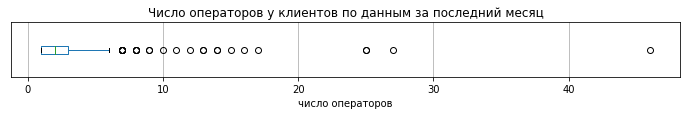

In [80]:
bills_last_month = bills[bills['month']=='2019-11']
bills_last_month.boxplot('operators', vert=False, figsize=(12,1))
plt.title('Число операторов у клиентов по данным за последний месяц')
plt.xlabel('число операторов')
plt.yticks([])
plt.show()

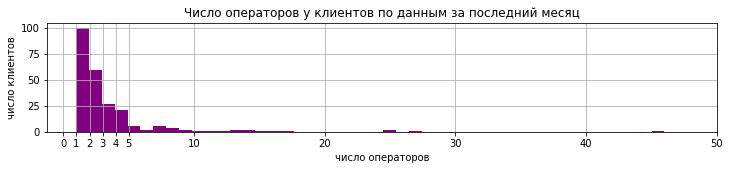

In [81]:
bills_last_month['operators'].hist(figsize=(12,2), 
    bins=bills_last_month['operators'].max(), color='purple')
plt.xticks(list(range(0,6)) + list(range(10,51,10)))
plt.title('Число операторов у клиентов по данным за последний месяц')
plt.ylabel('число клиентов')
plt.xlabel('число операторов')
plt.show()

Диаграммы показывают, что распределение далеко от нормального. Оно сильно смещено в область малых значений и имеет большое число выбросов. Для большинства клиентов характерно малое число операторов (1 - 4). В то же время отдельные клиенты располагают штатом от 20 до 50 операторов.

Оценим, как у среднестатистического клиента менялось число операторов в течение времени. В виду характера распределения основной мерой среднего выберем медиану, но для справки отобразим также и среднее арифметическое (на нём сильно сказывается появление клиентов с экстремальным числом операторов, но это может быть интересно):

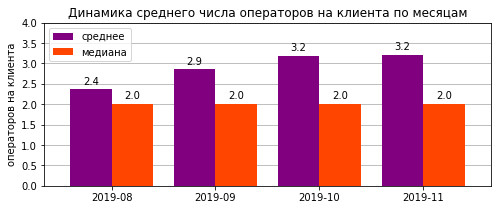

In [82]:
report = bills.groupby('month')['operators'].agg(['mean', 'median'])
report = report.rename(columns={'mean':'среднее', 'median':'медиана'})
report.index = report.index.strftime('%Y-%m')
ax = report.plot.bar(figsize=(8,3), rot=0, color=['purple','orangered'], width=0.8)
ax.set_title('Динамика среднего числа операторов на клиента по месяцам')
ax.set_ylabel('операторов на клиента')
ax.set_xlabel('')
ax.set_ylim(0,4)
ax.grid(axis='y')
ax.set_axisbelow(True)
annotate_bars(ax, '{:.1f}')
plt.show()

За четыре месяца среднее число операторов на клиента практически не менялось. Половина клиентов имеет одного-двух операторов, другая половина - от 3 до 50. Судя по отсутствую динамики, это соотношение между клиентами в ближайшем будующем не изменится.

#### Количество соединений

<a id="calls-count-box"></a>Узнаем распределение клиентов в зависимости от числа вызовов, закончившихся соединением (разговором). Для этого отобразим диаграмму размаха и гистограмму по данным за последний месяц:

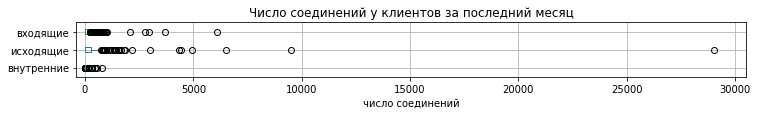

In [83]:
bills_last_month.boxplot(['int_count','out_count','in_count'], figsize=(12,1), vert=False)
plt.yticks(range(1,4), labels=['внутренние','исходящие','входящие'])
plt.xlim(-400,)
plt.title('Число соединений у клиентов за последний месяц')
plt.xlabel('число соединений')
plt.show()

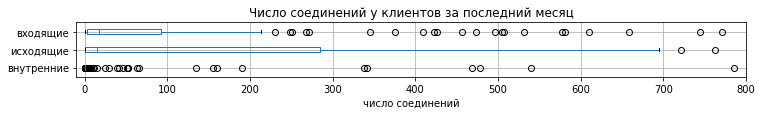

In [84]:
bills_last_month.boxplot(['int_count','out_count','in_count'], figsize=(12,1), vert=False)
plt.yticks(range(1,4), labels=['внутренние','исходящие','входящие'])
plt.xlim(-10, 800)
plt.title('Число соединений у клиентов за последний месяц')
plt.xlabel('число соединений')
plt.show()

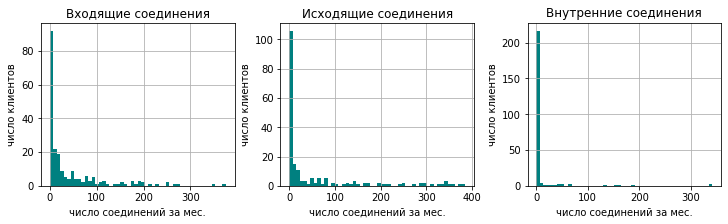

In [85]:
figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,3), constrained_layout=True)
for ax, name, column in [(axes[0],'Входящие','in_count'), (axes[1],'Исходящие','out_count'), 
        (axes[2],'Внутренние','int_count')]:
    bills_last_month.loc[bills_last_month[column] < 400, column].hist(
        ax=ax, bins=50, color='teal')
    ax.set_title(name + ' соединения')
    ax.set_ylabel('число клиентов')
    ax.set_xlabel('число соединений за мес.')
plt.show()

Диаграммы показывают, что распределения далеки от нормального. Они сильно смещены в область малых значений и имееют большое число выбросов. Большинство клиентов совершает незначительное число соединений. Хотя среди клиентов есть и такие, у которых число соединений идёт на тысячи в месяц (1000/30=33 в сутки) и даже есть один клиент примерно с 30 тыс. соединений в месяц (30000/30=1000 в сутки).

<a id="calls-count-dynamics"></a>Оценим, как менялось число соединений среднестатистического клиента за последние месяцы. В виду характера распределения в качестве меры среднего возьмём медиану:

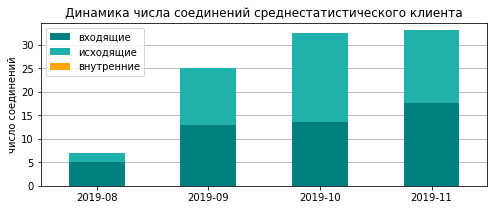

In [86]:
report = bills.groupby('month')[['in_count','out_count','int_count']].median()
report.index = report.index.strftime('%Y-%m')
ax = report.plot.bar(figsize=(8,3), stacked=True, rot=0, color=['teal','lightseagreen','orange'])
ax.set_title('Динамика числа соединений среднестатистического клиента')
ax.set_ylabel('число соединений')
ax.set_xlabel('')
ax.legend(['входящие','исходящие','внутренние'])
ax.grid(axis='y')
ax.set_axisbelow(True)
savefig()
plt.show()

В первые месяцы по мере подключения к тарифам новых клиентов среднее число вызовов на клиента росло. В последний месяц практически прекратилось. Вместе со стабилицацией клиентской базы, стабилизировалось и среднее число вызовов на клиента: 50% входящих соединений, 50% исходящих, внутренних содениений - исчезающе мало.

#### Длительность соединений

<a id="calls-duration-box"></a>Оценим распределение длительности соединений среднестатистического клиента. Для этого отобразим диаграмму размаха и гистограмму по данным за последний месяц:

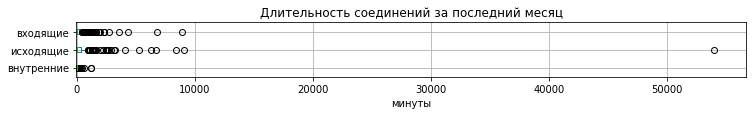

In [87]:
# Берём длительность разговоров за последний месяц
duration_last_month = bills_last_month[['int_duration','out_duration','in_duration']].copy()
duration_last_month = duration_last_month / 60

duration_last_month.boxplot(figsize=(12,1), vert=False)
plt.yticks(range(1,4), labels=['внутренние','исходящие','входящие'])
plt.title('Длительность соединений за последний месяц')
plt.xlabel('минуты')
plt.xlim(-50,)
plt.show()

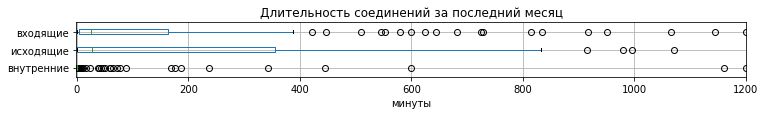

In [88]:
duration_last_month.boxplot(figsize=(12,1), vert=False)
plt.yticks(range(1,4), labels=['внутренние','исходящие','входящие'])
plt.title('Длительность соединений за последний месяц')
plt.xlabel('минуты')
plt.xlim(-1, 1200)
plt.show()

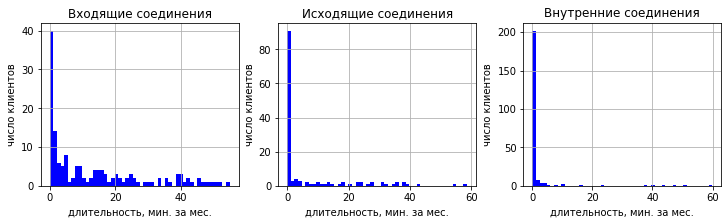

In [89]:
figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,3), constrained_layout=True)
for ax, name, column in [(axes[0],'Входящие','in_duration'), (axes[1],'Исходящие','out_duration'), 
        (axes[2],'Внутренние','int_duration')]:
    duration_last_month.loc[duration_last_month[column] <= 60, column].hist(
        ax=ax, bins=50, color='blue')
    ax.set_title(name + ' соединения')
    ax.set_xlabel('длительность, мин. за мес.')
    ax.set_ylabel('число клиентов')
plt.show()

Диаграммы показывают, что распределения далеки от нормального. Они сильно смещены в область малых значений и имееют большое число выбросов. Суммарное (за месяц) вермя соединений значительного числа клиентов исчисляется считанными минутами. При этом существует заметное число клиентов, которые в среднем за месяц накапливают тысячи минут разговоров.

<a id="talks"></a>Оценим динамику изменения длительности соединений среднестатистического клиента во времени. Ввиду характера распределения в качестве меры среднего используем медиану:

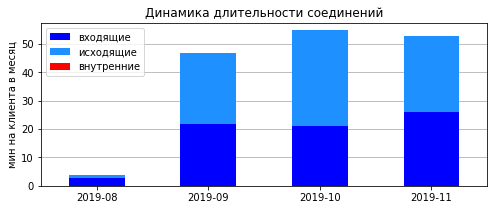

In [90]:
report = bills.groupby('month')[['in_duration','out_duration','int_duration']].median()
report = report / 60
report.index = report.index.strftime('%Y-%m')
ax = report.plot.bar(figsize=(8,3), stacked=True, rot=0, color=['blue','dodgerblue','red'])
ax.set_title('Динамика длительности соединений')
ax.set_ylabel('мин на клиента в месяц')
ax.set_xlabel('')
ax.legend(['входящие','исходящие','внутренние'])
ax.grid(axis='y')
ax.set_axisbelow(True)
savefig()
plt.show()

В первые два месяца среднее число соединений клиентов активно росло. В последние два месяца заметного изменения нет. Видимо по мере роста числа клинетов показатель стабилизировался. На протяжении всего времени соотношение в длительности разговоров между разными видами соединений не изменилось: 50% длительности приходится на входящие соединения, 50% - на исходящие, доля внутренних соединений исчезающе мала.

#### Суммарный доход

<a id="total-income-dynamics"></a>Оценим динамику суммарного дохода от клиентов:

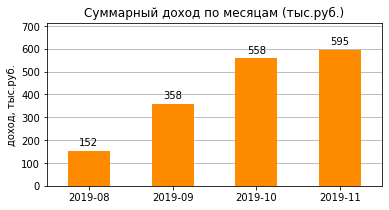

In [91]:
report = bills.groupby('month')['bill'].sum()
report = report / 1000
report.index = report.index.strftime('%Y-%m')
ax = report.plot.bar(figsize=(6,3), rot=0, color='darkorange')
ax.set_title('Суммарный доход по месяцам (тыс.руб.)')
ax.set_ylabel('доход, тыс.руб.')
ax.set_xlabel('')
ax.set_ylim(0,report.max()*1.2)
ax.grid(axis='y')
ax.set_axisbelow(True)
annotate_bars(ax)
savefig()
plt.show()

Доходы росли по мере подключения к тарифам новых клиентов. В последний месяц рост почти прекратился.

#### Средняя доходность

<a id="client-income-box"></a>Оценим, как распределены клиенты по сумме дохода, который они приносят. Для этого построим диаграммы размаха и гистограмму по данным за последний месяц:

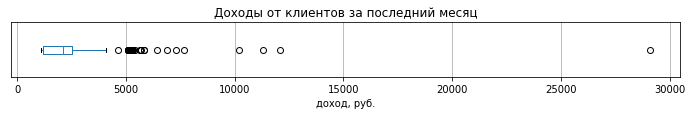

In [92]:
bills_last_month.boxplot('bill', figsize=(12,1), vert=False)
plt.title('Доходы от клиентов за последний месяц')
plt.xlabel('доход, руб.')
plt.yticks([])
plt.show()

<a id="client-income-hist"></a>

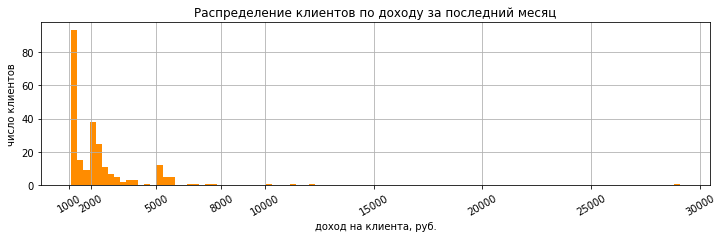

In [93]:
bills_last_month['bill'].hist(figsize=(12,3), bins=100, color='darkorange')
plt.title('Распределение клиентов по доходу за последний месяц')
plt.xticks([1000, 2000, 8000] + list(range(5000,30001,5000)), rotation=30)
plt.ylabel('число клиентов')
plt.xlabel('доход на клиента, руб.')
savefig()
plt.show()

Доходность от клиентов не имеет нормального распределения. Большинство клиентов приносит доход близкий размеру абонентской платы за тариф (1000, 2000 и ~~3000~~ 5000 руб.). В то же время существуют отдельные клиенты, которые приносят доход в размере от 10 до 30 тыс. руб. в месяц.

<a id="income-per-client"></a>Оценим динамику средней доходности клиента во времени. В виду характера распределения в качестве основной меры среднего возьмём медиану, но параллельно отобразим и среднее арифметическое (на нём сильно сказывается появление клиентов с экстремальной доходностью, но это может быть интересно):

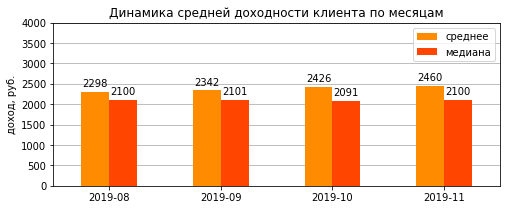

In [94]:
report = bills.groupby('month')['bill'].agg(['mean','median'])
report.index = report.index.strftime('%Y-%m')
ax = report.plot.bar(figsize=(8,3), rot=0, color=['darkorange','orangered'])
ax.set_title('Динамика средней доходности клиента по месяцам')
ax.set_ylabel('доход, руб.')
ax.legend(['среднее','медиана'])
ax.set_xlabel('')
ax.set_ylim(0,4000)
ax.grid(axis='y')
ax.set_axisbelow(True)
annotate_bars(ax)
plt.show()

Средняя доходность клиента практически не меняется с течением времени. Половина клиентов приносит доход от 1000 до 2100 руб. в месяц. Вторая половина клиентов имеет значительно больший разброс - от 2100 до 30 тыс. руб.

#### Итоги

По результатам исследования динамики и состава клиентов можно сделать следующие выводы:

1. Первые месяцы шло активное подключение к тарифам новых клиентов. В последнем месяце рост прекратился. По мере стабилизации числа клиентов стабилизировался и ряд их параметров: среднее число соединений и средняя длительность разговоров. Ряд параметров клиентов был стабилен независимо от роста клиентской базы: число операторов и средний доход (приносимый клиентом).  

2. В среднем клиенты имеют очень низкие значения параметров: 2 оператора на клиента, 35 звонков в месяц, длительность соединений - 50 минут в месяц. Средний доход от клиента равен 2100 руб. в мес. Большинство клиентов приносят доход, близкий к абонентской плате (1000, 2000 и 5000 руб. в мес.).

3. Та половина клиентов, чьи характеристики выше среднего, имеют очень большой размах характеристик, на порядки превышающий средние значения: от 2 до 50 операторов, от 35 до 30 тыс. соединений в месяц, от 50 до 55 тыс. минут разговора в месяц, от 2100 до 30 тыс. руб. дохода в месяц.

4. Для клиентов в среднем характерно следующее соотношение соединений (как по количеству, так и по длительности): 50% - входящие соединения, 50% - исходящие соединение, число и длительность внутренних разговоров исчезающе мала.

<a id="tariffs"></a>

### Тарифы

#### Динамика

<a id="tariffs-dynamics"></a>Узнаем, как менялись доходность и число пользователей тарифов во времени:

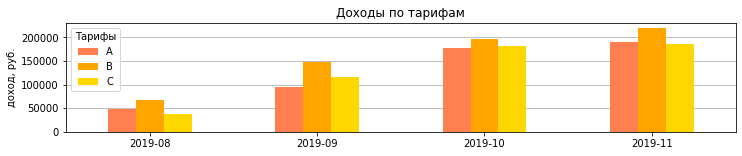

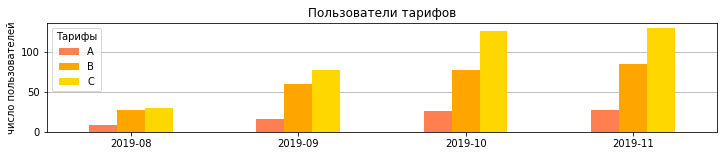

In [95]:
tariff_colors = ['coral', 'orange', 'gold']

def plot_tariff_history(data, column, func, title, ylabel):
    report = data.pivot_table(index='month', columns='tariff', values=column, aggfunc=func)
    report.index = report.index.strftime('%Y-%m')
    report.columns.name = 'Тарифы'

    ax = report.plot.bar(figsize=(12,2), color=tariff_colors, rot=0)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    ax.set_xlabel('')
    plt.show()

plot_tariff_history(bills, 'bill', 'sum', 'Доходы по тарифам', 
    'доход, руб.')
plot_tariff_history(bills, 'user_id', 'nunique', 'Пользователи тарифов', 
    'число пользователей')

Из графиков видно, что доходы менялись по мере роста пользователй тарифов: в первые месяцы росли, в последний - перестали. Соотношение пользователей разных тарифов на протяжении времени существенно не меняется: доходы от разных тарифов примерно равны, число пользователей у тарифа А - наименьшее, у тарифа В - среднее, у тарифа С - наибольшее.

<a id="tariffs-clients-dynamics"></a>Узнаем, как менялись тарифицируемые параметры у пользователей разных тарифов во времени:

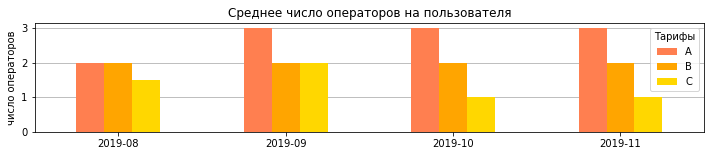

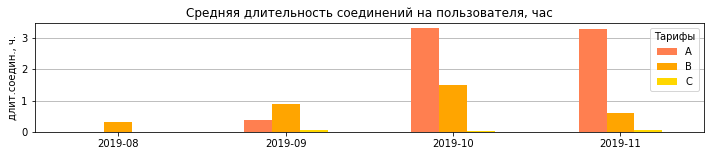

In [96]:
bills_ext = bills.copy()
bills_ext['duration'] = (bills['int_duration'] + bills['out_duration']) / 60 / 60

plot_tariff_history(bills_ext, 'operators', 'median', 'Среднее число операторов на пользователя', 
    'число операторов')
plot_tariff_history(bills_ext, 'duration', 'median', 'Средняя длительность соединений на пользователя, час', 
    'длит.соедин., ч.')

Среднее число операторов у пользоватей разных тарифов и мало отличается и во времени практически не меняется. Средняя длительность соединений многократно выше у пользователья тарифа А и растёт, у пользователей тарифов В и С колеблется на низком уровне (у пользователй тарифа С - близка к нулю).

#### Доходность и популярность

<a id="tariffs-income-n-users"></a>Узнаем как распределён доход и пользователи между тарифами по данным за последний месяц:

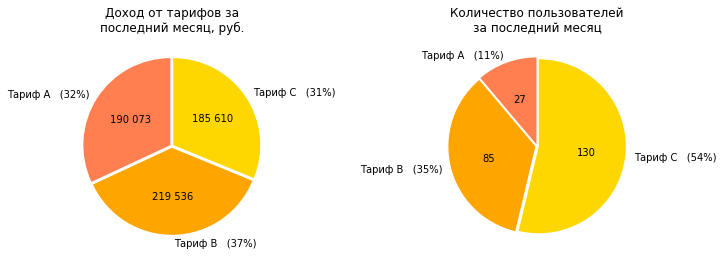

In [97]:
def plot_tariff_pie(ax, data, column, func, title, angle=0):
    # Считаем 
    report = data.groupby('tariff')[column].agg(func)
    report = report.to_frame()
    total = report[column].sum()
    report.index = report.apply(axis=1, func=lambda row: 'Тариф {t}   ({p:.0%})'.format(
        t=row.name, p=row[column]/total))
    # Рисуем
    report[column].plot.pie(ax=ax, pctdistance=0.55, startangle=angle, 
        autopct=lambda p: '{:,.0f}'.format(total*p/100).replace(',',' '),
        colors=tariff_colors, explode=[0.02,0.02,0.02])
    ax.set_title(title)
    ax.set_ylabel('')


figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
angle = 90
plot_tariff_pie(axes[0], bills_last_month, 'bill', 'sum', 
    'Доход от тарифов за\nпоследний месяц, руб.', angle)
plot_tariff_pie(axes[1], bills_last_month, 'user_id', 'count', 
    'Количество пользователей\nза последний месяц', angle)
savefig()
plt.show()

Доход от тарифов примерно равен для всех тарифов - треть от общего. Кол-во пользователей сильно разнится: 12%, 35% и 53% для тарифов A, В и С соответственно. Получается, что существенно разные по численности пользователей группы дают примерно одинаковый доход. Пользователи тарифа А в этом плане наиболее ценные, пользователи тарифа В на среднем уровне, пользователи тарифа С имеют наименьшую ценность.

<a id="#users"></a>

#### Параметры пользователей

<a id="tariffs-users-properties"></a>Узнаем соотношение характеристик среднего пользователя каждого тарифа за последний месяц:

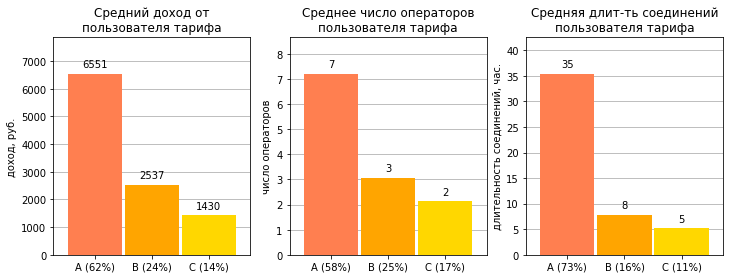

In [98]:
figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
title = ['Средний доход от', 'Среднее число операторов', 'Средняя длит-ть соединений']
ylabel = ['доход, руб.', 'число операторов', 'длительность соединений, час.']
for i, column in enumerate(['bill', 'operators', 'duration']):
    report = bills_ext.groupby('tariff')[column].mean()
    report = report.to_frame()
    total  = report[column].sum()
    report.index = report.apply(axis=1, func=lambda row: '{t} ({p:.0%})'.format(
        t=row.name, p=row[column] / total))
    ax = axes[i]
    report[column].plot.bar(ax=ax, color=tariff_colors, width=0.95, rot=0)
    ax.set_title(title[i] + '\nпользователя тарифа')
    ax.set_ylabel(ylabel[i])
    ax.set_ylim(0, report[column].max()*1.2)
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    annotate_bars(ax, '{:.0f}')
savefig()
plt.show()

Из графиков видно, что средний пользователь тарифа А приносит в 5-6 раз больших доход по сравнению с пользователями других тарифов. Пользователи этого тарифа также в среднем обладают в 2-3 раза большим штатом операторов, а суммарная длительность соедиенений у них в 8-12 раз превышает длительность соединений пользователей тарифов В и С.

#### Итоги

По результатам исследования динамики тарифов и их пользователей можно сделать следующие выводы:
1. К последнему месяцу доходы от тарифов стабилизировались как по структуре так и по объёмам. Тарифы дают одинаковый доход, но при этом сильно разнятся по числу пользователей.
2. Пользователи тарифов в последние два месяца имеют стабильное, схожее друг с другом число операторов. Длительность вызовов для разных тарифов во времени продолжает меняться. У тарифа А этот показатель активно растёт во много раз превосходит тарифы В и С. Длительность разговоров для последних колеблется на низком уровне.
3. Средний пользователь тарифа А также многократно превосходит по всем характеристикам пользователей тарифов В и С (и по приносимому доходу, и по числу операторов, и по длительности вызовов). Показатели средних пользователей тарифов В и С различнятся, но не более чем в полтора-два раза. 

<a id="tariffs-best"></a>

## Оптимальные тарифы

### Расчёт оптимальных тарифов

<a id="better-tariff-func"></a>Создадим функцию, которая выбирает для клиентов тариф, с минимальной платой за полученные услуги связи:

In [99]:
def count_bills_min(calls, tariffs):
    # Данные биллинга на три тарифа для каждого абонента
    bills_a = calls.drop(columns=['month','in_count','out_count', 
        'int_count','in_duration','bill'])
    bills_a['out_duration'] = np.ceil(bills_a['out_duration'] / 60)
    bills_a['int_duration'] = np.ceil(bills_a['int_duration'] / 60)
    bills_a['tariff'] = 'A'
    bills_b = bills_a.copy()
    bills_b['tariff'] = 'B'
    bills_c = bills_a.copy()
    bills_c['tariff'] = 'C'
    bills_x = bills_a
    bills_x = bills_x.append(bills_b)
    bills_x = bills_x.append(bills_c)

    # Начисление
    bills_x = bills_x.merge(tariffs, on='tariff')
    bills_x['int_duration'] = bills_x['int_duration'] - bills_x['int_ignore']
    bills_x.loc[bills_x['int_duration'] < 0, 'int_duration'] = 0 
    bills_x['bill'] = bills_x['base'] \
        + bills_x['operators'] * bills_x['operator_price'] \
        + bills_x['int_duration'] * bills_x['int_price'] \
        + bills_x['out_duration'] * bills_x['out_price'] 

    # Оптимальный
    bills_x = bills_x[['user_id','tariff','bill']]
    bills_min = bills_x.groupby('user_id')['bill'].min()
    bills_x = bills_x.join(bills_min, on='user_id', rsuffix='_min')
    bills_x = bills_x.sort_values(['user_id','tariff'])
    bills_x = bills_x[bills_x['bill']==bills_x['bill_min']]
    bills_min = bills_x.groupby('user_id')['tariff'].min()
    bills_x = bills_x.join(bills_min, on='user_id', rsuffix='_min')
    bills_x = bills_x[['user_id','tariff_min','bill_min']]
    bills_x = bills_x.drop_duplicates()
    bills_x = bills_x.set_index('user_id')
    
    return bills_x

Рассчитаем лучшие тарифы для клиентов по данным последнего месяца:

In [100]:
tariff_columns = ['tariff','base','operator_price','int_ignore', 'int_price','out_price']
tariffs = pd.DataFrame(columns=tariff_columns)
tariffs.loc[0, tariff_columns] = ['A', 5000, 100, 2000, 0.10, 0.40]
tariffs.loc[1, tariff_columns] = ['B', 2000, 100, 2000, 0.15, 0.50]
tariffs.loc[2, tariff_columns] = ['C', 1000, 100, 2000, 0.30, 0.70]

bills_min = count_bills_min(bills_last_month, tariffs)

<a id="better-tariffs-table"></a>Выясним, сколько клиентов могут выбрать тариф, по которому будут платить меньше, чем по текущему:

In [101]:
tariffs_diff = bills_min.join(bills_last_month[['user_id', 'tariff', 'bill']]
    .set_index('user_id'))

users_with_better_tariff = tariffs_diff[(tariffs_diff['bill'] > tariffs_diff['bill_min'])]
change_to_better = users_with_better_tariff.groupby(['tariff', 'tariff_min'])[['bill']].count()
change_to_better = change_to_better.reset_index().set_index('tariff')
change_to_better.columns = ['better_tariff', 'users_to_go']
change_to_better['users_total'] = bills_last_month.groupby('tariff')[['user_id']].count()
change_to_better['users_to_go_part'] = change_to_better['users_to_go'] / change_to_better['users_total']
change_to_better

,better_tariff,users_to_go,users_total,users_to_go_part
tariff,,,,
A,B,3,27,0.111111
A,C,23,27,0.851852
B,C,83,85,0.976471


Клиенты тарифов А и В либо переоценили свои потребности в услугах связи, либо планируют развитие, которое пока не состоялось. Так или иначе, но они переплачивают, и алгоритм советует им - всем, кроме одного-двух - перейти на более дешёвые тарифы.

<a id="income-lost"></a>

### Упущенный доход

Расчитаем, насколько снизится доход, если все клиенты перейдут на оптимальные тарифы:

In [102]:
last_month_income = bills_last_month['bill'].sum()
last_month_tariff_values = bills_last_month['tariff'].value_counts()
(bills_min['bill_min'].sum() - last_month_income) / last_month_income

-0.2919098194261574

Доход сократится почти на треть, если все пользователи, которые могут, перейдут на оптимальные тарифы.

<a id="calculator"></a>

### Компенсация упущенного дохода

Постараемся компенсировать снижение доходов из-за возможного перехода всех клиентов на оптимальные тарифы. Запустим расчёт коэффициентов изменения. Значения коэффициентов покажут, в какой степени мы должны изменить стоимость тех или иных услуг в тарифных планах, чтобы компенсировать снижение дохода. Рассчитаем коэффициенты изменения абонентской платы (коэффициент fix), платы за оператора (oper) и стоимости минуты звонка (call):

In [103]:
print('  fix  oper  call  incomes_diff')
print('---')
income_diff_min = float('inf')
for xp in [100, 115, 120, 150, 170]:
    x = xp / 100
    for yp in [100, 120, 150, 200]:
        y = yp / 100
        for zp in [100, 120, 150, 200]:
            z = zp / 100
            tariffs_new = pd.DataFrame(columns=tariff_columns)
            tariffs_new.loc[0, tariff_columns] = ['A', 5000*x, 100*y, 2000, 0.10*z, 0.40*z]
            tariffs_new.loc[1, tariff_columns] = ['B', 2000*x, 100*y, 2000, 0.15*z, 0.50*z]
            tariffs_new.loc[2, tariff_columns] = ['C', 1000*x, 100*y, 2000, 0.30*z, 0.70*z]
            bills_min = count_bills_min(bills_last_month, tariffs_new)
            income_diff = abs(bills_min['bill_min'].sum() - last_month_income)
            p = income_diff / last_month_income * 100
            if income_diff <= income_diff_min:
                income_diff_min = income_diff
            if p < 1.1:
                print(' '.join(['{:>4.0f}%'.format(v-100) for v in (xp,yp,zp)]), 
                      '      {:.1f}%'.format(p))
print('---')

  fix  oper  call  incomes_diff
---
   0%  100%  100%       0.8%
  15%   50%  100%       0.9%
  20%  100%   50%       0.1%
  50%    0%   50%       0.3%
  70%    0%    0%       0.1%
---


Компенсировать выпадающие доходы (с точностью до процента от текущего размера месячного дохода) поможет либо двукратное увеличение на всех тарифах цен на подключение оператора и минут соединения одновременно, либо 70-процентное увеличение абонентской платы на всех тарифах, либо промежуточные варианты из таблицы выше.

<a id="risk"></a>

### Снижение риска

Снизить риск быстрой потери доходов от перехода абонентов на оптимальные тарифы можно, если растянуть процесс и предлагать сменить тариф не всем абонентам, а только некоторым из них, например, только абонентам тарифов В и С, но только не абонентам тарифа А. Абоненты тарифа А (как было показано выше) приносят в среднем доход многократно превышающий доход от абонентов тарифов В и С. Рассчитаем, насколько упадут доходы, если на более выгодные тарифы перейдут абоненты всех тарифов, кроме А:

In [104]:
bills_a = bills_last_month[bills_last_month['tariff']=='A']
bills_bc = bills_last_month[bills_last_month['tariff']!='A']
bills_bc_min = count_bills_min(bills_bc, tariffs)

x_min, x = bills_bc_min['bill_min'].sum() + bills_a['bill'].sum(), bills_last_month['bill'].sum()
round((x_min - x) / x_min, 2)

-0.15

Если тарифы сменят только абоненты тарифов В и С, то доход упадёт не на 29%, а на 15%. Убыток сократится почти в два раза! При этом число перешедших на более выгодные тарифы клиентов сократится лишь на четверть: 27/(27+83)=0.25.

<a id="hypos"></a>

## Статистические гипотезы

<a id="hypo-low-income"></a>

### Переход на оптимальные тарифы снижает доход

Проверим, верно ли, что переход пользователей на оптимальные тарифы снижает средний доход от пользователя? Как показано выше, суммарный доход снизился, но может быть это совпадение случайных факторов и на самом деле разница в средних доходах в расчёте на пользователя статистически незначима?

Сначала сохраним доход до смены тарифов и рассчитаем доход после смены тарифов:

In [105]:
tariffs = pd.DataFrame(columns=tariff_columns)
tariffs.loc[0, tariff_columns] = ['A', 5000, 100, 2000, 0.10, 0.40]
tariffs.loc[1, tariff_columns] = ['B', 2000, 100, 2000, 0.15, 0.50]
tariffs.loc[2, tariff_columns] = ['C', 1000, 100, 2000, 0.30, 0.70]

bills_last_month = bills[bills['month']==bills['month'].max()]
bills_min = count_bills_min(bills_last_month, tariffs)

Перед тем как проверять гипотезы изучим распределение сравниваемых величин и их средние значения:

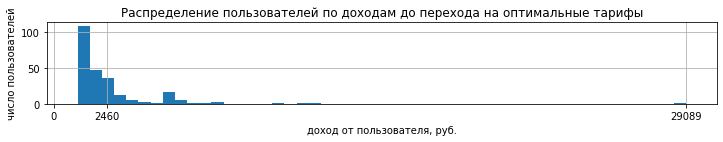

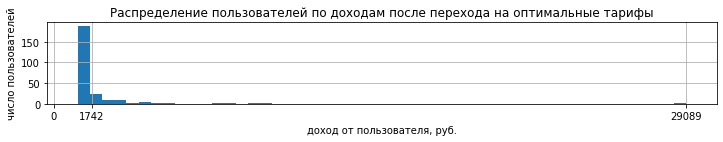

In [106]:
def show_hist(data, bins=10, title='', xlabel='', ylabel=''):
    data.hist(figsize=(12,1.5), bins=bins)
    plt.xticks([0, data.mean(), data.max()])
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()

show_hist(bills_last_month['bill'], bins=50,
    title='Распределение пользователей по доходам до перехода на оптимальные тарифы',
    xlabel='доход от пользователя, руб.',
    ylabel='число пользователей'    
    )
show_hist(bills_min['bill_min'], bins=50,
    title='Распределение пользователей по доходам после перехода на оптимальные тарифы',
    xlabel='доход от пользователя, руб.',
    ylabel='число пользователей'    
    )

Так как распределение не является нормальным для проверки гипотез будем использовать критерий Манна-Уитни.

**Нулевая гипотеза Н0:** средний доход на пользователя для выборок до и после перехода на оптимальные тарифы не различается.

**Альтернативная гипотеза H1:** средний доход на пользователя снизился после перехода на оптимальные тарифы.

Проверка:

In [107]:
result = st.mannwhitneyu(bills_last_month['bill'], bills_min['bill_min'], 
    True, 'greater')
p_value = result[1]
p_value

9.265943289976692e-10

Уровень статистической значимости значительно ниже 0.05 (и даже 0.01). Данные противоречат нулевой гипотезе, она должна быть отвергнута и вместо неё принята альтернативная гипотеза. Таким образом разница в выборках статистически значима и смена тарифов на оптимальные действительно снижает средний доход от пользователя тарифа.

<a id="hypo-b-better-c"></a>

### Пользователи тарифа В превосходят пользователей тарифа С

В разделах выше было показано, что пользовтели тарифов В и С схожи в параметрах по сравнению с пользователями тарифа А. Пользователи тарифа А имеют в средем в разы большие значения, чем у пользователи тарифов В и С. Последние же разнятся между собой не более чем в полтора-два раза. Интересно узнать, значима ли такая разница или это случайное расхождение? Вопрос тем более актуален, что алгоритм выбора оптимальных тарифов посоветовал почти всем пользователям тарифа В перейти на тариф С.

#### Доход

Выясним, верно ли что средний доход от пользователя тарифа В больше, чем средний доход от пользователя тарифа С.

Перед тем как проверять гипотезы, изучим распределение сравниваемых величин и их средние значения:

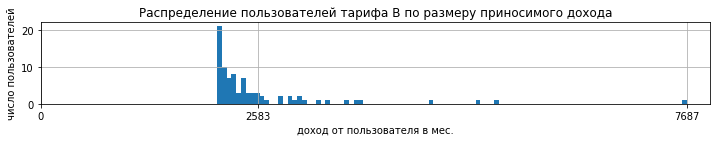

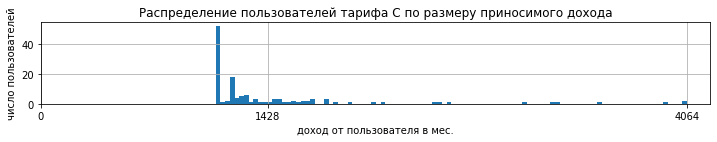

In [108]:
show_hist(bills_last_month[bills_last_month['tariff']=='B']['bill'], bins=100,
    title='Распределение пользователей тарифа В по размеру приносимого дохода',
    xlabel='доход от пользователя в мес.',
    ylabel='число пользователей'    
    )
show_hist(bills_last_month[bills_last_month['tariff']=='C']['bill'], bins=100,
    title='Распределение пользователей тарифа С по размеру приносимого дохода',
    xlabel='доход от пользователя в мес.',
    ylabel='число пользователей'    
    )

Так как распределение не является нормальным для проверки гипотез будем использовать критерий Манна-Уитни.

**Нулевая гипотеза Н0:** средний доход от пользователей тарифов В и С одинаков.

**Альтернативная гипотеза H1:** средний доход от пользователей тарифа В больше, чем от пользователей тарифа С.

Проверка:

In [109]:
result = st.mannwhitneyu(
    bills_last_month[bills_last_month['tariff']=='B']['bill'],
    bills_last_month[bills_last_month['tariff']=='C']['bill'],
    True, 'greater'
    )
p_value = result[1]
p_value

3.22904562882801e-27

Уровень статистической значимости значительно ниже 0.05 (и даже 0.01). Данные противоречат нулевой гипотезе, она должна быть отвергнута и вместо неё принята альтернативная гипотеза. Таким образом разница в выборках статистически значима и средний доход от пользователя тарифа В больше среднего дохода от пользователя тарифа С.

#### Операторы

Выясним, верно ли, что число операторов у пользователей тарифа В больше, чем у пользователей тарифа С.

Перед тем как проверять гипотезы, изучим распределение сравниваемых величин и их средние значения:

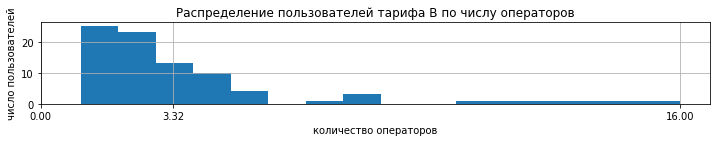

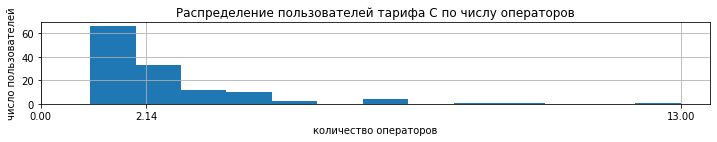

In [110]:
show_hist(bills_last_month[bills_last_month['tariff']=='B']['operators'], bins=16,
    title='Распределение пользователей тарифа В по числу операторов',
    xlabel='количество операторов',
    ylabel='число пользователей'    
    )
show_hist(bills_last_month[bills_last_month['tariff']=='C']['operators'], bins=13,
    title='Распределение пользователей тарифа C по числу операторов',
    xlabel='количество операторов',
    ylabel='число пользователей'    
    )

Так как распределение не является нормальным для проверки гипотез будем использовать критерий Манна-Уитни.

**Нулевая гипотеза Н0:** среднее число операторов пользователей тарифов В и С одинаково.

**Альтернативная гипотеза H1:** среднее число операторов пользователей тарифов В больше, нежели у пользователей тарифа С.

Проверка:

In [111]:
result = st.mannwhitneyu(
    bills_last_month[bills_last_month['tariff']=='B']['operators'],
    bills_last_month[bills_last_month['tariff']=='C']['operators'],
    True, 'greater')
p_value = result[1]
p_value

0.00021423013997827668

Уровень статистической значимости значительно ниже 0.05 (и даже 0.01). Данные противоречат нулевой гипотезе, она должна быть отвергнута и вместо неё принята альтернативная гипотеза. Таким образом разница в выборках статистически значима и среднее число операторов у пользователей тарифов В больше, чем у пользователй тарифа С различно.

#### Соединения

Выясним, совпадает средняя длительность разговоров у пользователей тарифов В и С.

Перед тем как проверять гипотезы, рассчитаем сравниваемые величины и изучим их распределение, а также средние значения:

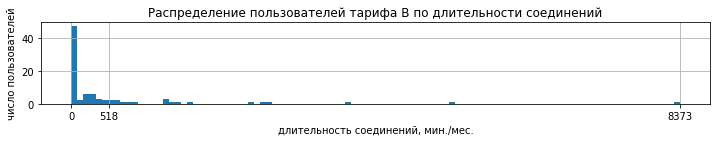

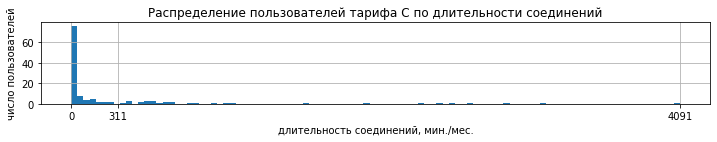

In [112]:
x = bills_last_month.copy()
x['tariff_minutes'] = (x['int_duration'] + x['out_duration']) / 60

show_hist(x[x['tariff']=='B']['tariff_minutes'], bins=100,
    title='Распределение пользователей тарифа В по длительности соединений',
    xlabel='длительность соединений, мин./мес.',
    ylabel='число пользователей'    
    )
show_hist(x[x['tariff']=='C']['tariff_minutes'], bins=100,
    title='Распределение пользователей тарифа C по длительности соединений',
    xlabel='длительность соединений, мин./мес.',
    ylabel='число пользователей'    
    )

Так как распределение не является нормальным для проверки гипотез будем использовать критерий Манна-Уитни.

**Нулевая гипотеза Н0:** средняя длительность соединений для пользователей В и С совпадают.

**Альтернативная гипотеза H1:** средняя длительность соединений у пользователей тарифа В больше, чем у пользователей тарифа С.

Проверка:

In [113]:
result = st.mannwhitneyu(
    x[x['tariff']=='B']['tariff_minutes'],
    x[x['tariff']=='C']['tariff_minutes'],
    True, 'greater')
p_value = result[1]
p_value

0.004626322457487433

Уровень статистической значимости значительно ниже 0.05 (и даже 0.01). Данные противоречат нулевой гипотезе, она должна быть отвергнута и вместо неё должна быть принята альтернативная гипотеза. Таким образом разница в выборках статистически значима и средняя длительность соединений у пользователей тарифа В больше, чем у пользователей тарифа С.

#### Итог

Проверка подтвердила статистическую значимость различий между пользователями тарифов В и С: параметры пользователей тарифа В - доход, число операторов, длительность соединений - все превосходят параметры пользователей тарифа С.

<a id="final"></a>

## Итоги

По итогам исследований следует сделать следующие выводы.

- **Бурный рост подключений к тарифам А, В, С завершился.** Количественные показатели (<a href="#client-number-dinamics">число клиентов</a> и <a href="#total-income-dynamics">суммарный доход</a>), а также качественные показатели (<a href="#income-per-client">средний доход</a>, <a href="#talks">звонки</a> и <a href="#tariffs-dynamics">динамика тарифов</a>) в течение четырёх месяцев выросли и стабилизировались.

- **Клиенты очень неоднородны.** Показатели потребления услуг и генерируемого дохода у разных клиентов могут различаться на многие порядки. Доход от клиента колеблется в диапазоне от 1 000 до <a href="#client-income-box">30 000 руб. в месяц</a>. Количество соединений - от 1 до <a href="#calls-count-box">30 000 соединений в месяц</a>. Длительность разговоров - от 1 <a href="#calls-duration-box">до 10 000 минут в месяц</a>.

- **Средний клиент потребляет мало услуг и приносит малый доход.** Средний доход, генерируемый половиной клиентов, не превышает <a href="#income-per-client">2 100 руб. в мес.</a>, среднее число соединений половины клиентов - не более <a href="#calls-count-dynamics">33 соединений в мес.</a>, средняя длительность соединений - не более <a href="#talks">50 мин. в мес</a>. Заметное число клиентов даёт доход, близкий или почти совпадающий с размером абонентской платы по тарифу (<a href="#client-income-hist">1000, 2000 и 5000 руб. в мес.</a>).

- **Тарифы приносят одинаковый доход, но пользователи у них разные.** Каждый тариф приносит примерно <a href="#tariffs-income-n-users">треть (200 тыс. руб.)</a> от суммарной выручки за месяц (600 тыс.руб.). При этом число пользователей существенно разнится: <a href="#tariffs-income-n-users">тариф А - 12%</a> пользователей, тариф В - 35%, тариф С - 53%. Соответственно существенно разнятся <a href="#tariffs-users-properties">доход, приносимый пользователем</a>, и объём потребляемых услуг: пользователи тарифа А приносят доход (и потребляют услуг) <a href="#tariffs-users-properties">в несколько раз</a> больше, чем пользователи тарифов В и С. Пользователи тарифа В опережают пользователей тарифа С в полтора-два раза. Статистическая <a href="#hypo-b-better-c">проверка</a> показывает, что эти различия не являются следствием случайных влияний текущих факторов.

- **Пользователи тарифов переплачивают.** <a href="#better-tariff-func">Алгоритм выбора наиболее выгодного тарифа</a> показывает, что подавляющему большинству пользователей тарифов А и В (<a href="#better-tariffs-table">более 90%</a>) следует сменить свой тариф на тариф С. Это значит, что пользователи переоценили свои потребности в услугах связи и переплачивают.

- **Преход на оптимальные тарифы приведёт к снижению дохода.** Переход пользователей на более выгодные тарифы сократит суммарный доход <a href="#income-lost">на 29%</a>. Статистическая <a href="#hypo-low-income">проверка</a> показывает, что это падение не может быть объяснено текущими случайными значениями различных факторов.

Рекомендации:

- **Привлечение новых клиентов и стимулирование имеющихся.** Следует привлекать крупных клиентов, схожих по профилю с текущими пользователями тарифа А. Они дают в несколько раз <a href="#tariffs-users-properties">больший доход</a>, их <a href="#tariffs-clients-dynamics">потребности в связи растут</a>. Имеющихся клиентов следует стимулировать. Способы стимулирования выходят за рамки данного проекта и требуют отдельного изучения.
- **Риск перехода пользователей на более дешёвые тарифы может быть снижен**, если предлагать сменить тариф не всем пользователям, которые могли бы это сделать, а <a href="#risk">только пользователям тарифа В</a>. Если на более выгодные тарифы перейдут только они, то при максимальном числе довольных возможностью съэкономить пользователей общий доход упадёт не на 29%, а лишь на 15%. 
- **Компенсировать снижение дохода можно изменением тарифов.** <a href="#calculator">Калькулятор изменения тарифов</a> позволяет расчтитать разные комбинации изменения параметров текущих тарифов для компенсации упущенного дохода. Например, расчёты показывают, что увеличение абонентской платы (на всех тарифах) на 70% полностью компенсирует переход всех пользователей на более экономные тарифы. Другой вариант: абонентская плата остаётся неизменной, но плату за оператора и минуту разговоров придётся увеличить на 100%. Возможны и <a href="#calculator">другие варианты</a>. 
